## This is a quicklook notebook where I take the target pixel file Geert Barentsen gave me and turn it into a light curve, fit some transits and searched for additional planets (spoiler: I didn't find any)

Geert made this stuff citable at https://zenodo.org/record/375796/

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits as pyfits
from astropy.stats.funcs import median_absolute_deviation as MAD
from scipy.ndimage import label

from fit_funcs import (bg_sub, get_label_im, get_lc, transit_fit,
                       get_qf, bin_data, model_ktransit, plot_model)
import untrendy

try:
    from blssearch import doSearch, plotSearch, get_qf
    dobls = True
except ImportError:
    dofls = False

# i saved some dictionaries with planet parameters
from planet_params import *

# because I'm being sloppy
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

%matplotlib inline

In [2]:
f = pyfits.open('ktwo245950175-unofficial-tpf-smear-corrected.fits')
data = f[1].data
print('{} cadences'.format(f[1].data['FLUX'].shape[0]))
print('pixel mask is {}'.format(f[1].data['FLUX'].shape[1:3]))

3599 cadences
pixel mask is (11, 11)


lets take a look at what the star looks like

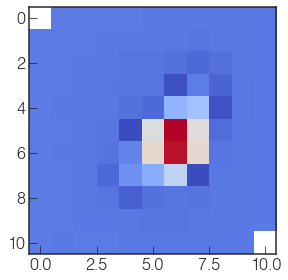

In [3]:
plt.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0])), cmap='coolwarm', aspect='equal', interpolation='nearest')
plt.tight_layout()

These are some constants that I fiddled around with a found seemed to work best

In [17]:
bg_cut = 0.15
n_chunks = 7.
flatlc_window = 1.5
smooth_window = 0.6

I'm going to extract flux from the flagged pixels

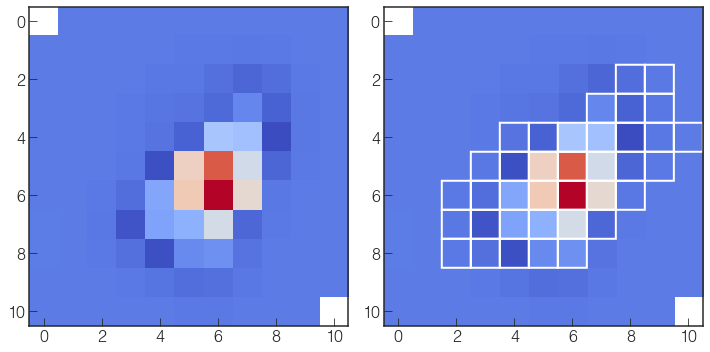

In [18]:
lab_im = get_label_im(np.copy(f[1].data['FLUX']), bg_cut)

fig, [ax1,ax] = plt.subplots(1, 2, figsize=[10,5])
ax.imshow(np.sqrt(np.abs(f[1].data['FLUX'][100])), cmap='coolwarm', aspect='equal', interpolation='nearest')
ax1.imshow(np.sqrt(np.abs(f[1].data['FLUX'][100])), cmap='coolwarm', aspect='equal', interpolation='nearest')
for i in range(11):
    for j in range(11):
        if lab_im[j,i] == 1:
            ax.add_patch(mpl.patches.Rectangle((i-.5, j-.5), 1, 1, hatch='', fill=False, snap=False, color='w', 
                                               lw=2))

plt.tight_layout()
plt.savefig('images/pixelmask.png')

I'm going to remove some cadences where we fire a thruster and remove energy from the reaction wheels, called a resat. Also, something weird happens with the pointing at the end of the campaign

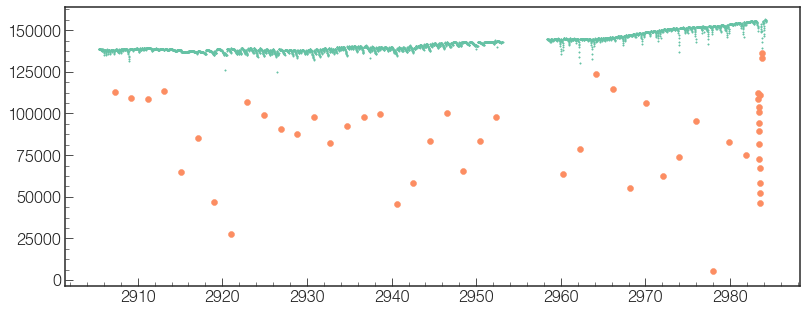

In [19]:
q1 = np.array([])
for i in np.arange(f[1].data['TIME'].shape[0]):
    q1 = np.r_[q1,np.sum(f[1].data['FLUX'][i][lab_im > 0.0])]

plt.figure(figsize=[12,5])
plt.scatter(f[1].data['TIME'],q1, s=2)

q = untrendy.median(f[1].data['TIME'],q1,dt=2)

plt.scatter(f[1].data['TIME'][(q1-q)<-15000],q1[(q1-q)<-15000])

badbadbad = (q1-q)<-15000

plt.minorticks_on()
# plt.savefig('images/rawlc.png')

2953.10573493 2958.3770587 5.27132377354
78.8870368712
73.6157130976


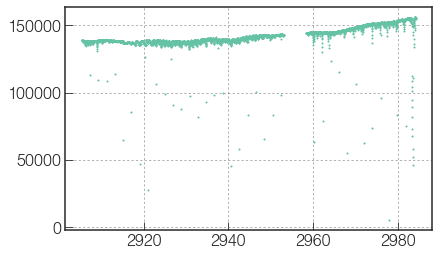

In [20]:
plt.scatter(f[1].data['TIME'],q1, s=2)
# plt.xlim(2953,2959)
plt.grid()

lt1 = f[1].data['TIME'][(f[1].data['TIME'] >2953) * (f[1].data['TIME'] <2954)][-1]
lt2 = f[1].data['TIME'][(f[1].data['TIME'] >2954) * (f[1].data['TIME'] <2959)][0]
print(lt1,lt2,lt2-lt1)
tt = f[1].data['TIME'][-1] - f[1].data['TIME'][0]
print(tt)
print(tt-(lt2-lt1))

ok now let's make a light curve, this uses a methods that's almost exactly like Andrew Vanderburg's

In [21]:
quality = np.zeros_like(np.copy(f[1].data['TIME']))
quality[badbadbad] = 100.
time, lc, xbar, ybar, t1, corflux, cfflux = get_lc(
    np.copy(f[1].data['TIME']), np.copy(f[1].data['FLUX']), 
    quality, n_chunks, bg_cut, flatlc_window, smooth_window)

lets make some plots
* undetrended light curve
* undetrended and the detrending model of the spots [it's a silly median filter]
* final product

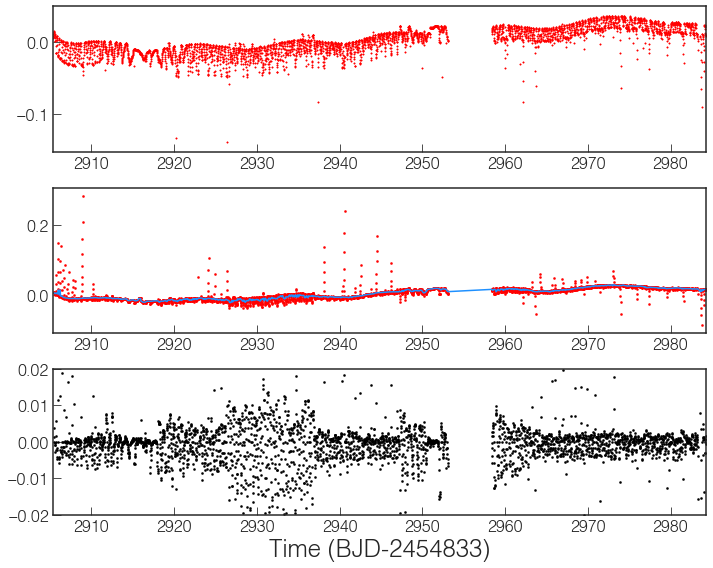

In [23]:
fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=[10,8])
ax1.scatter(time,lc/np.median(lc)-1.0, color='r', s=2)
# ax1.set_ylim([-0.02,0.02])
ax1.set_xlim(np.min(time), np.max(time))

q = untrendy.median(t1,corflux,dt=smooth_window)
ax2.scatter(t1,corflux-1.0, color='r',s=4)
ax2.plot(t1, q-1.0, color='dodgerblue')
# ax2.set_ylim([-0.02,0.02])
ax2.set_xlim(np.min(time), np.max(time))

ax3.set_ylim([-0.02,0.02])
ax3.set_xlim(np.min(time), np.max(time))
ax3.scatter(t1,cfflux, color='k',s=4)

ax3.set_xlabel('Time (BJD-2454833)')

fig.tight_layout()
# plt.savefig('images/lcdetrending.png')

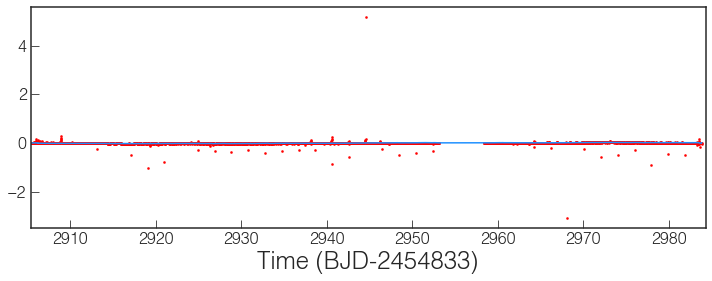

In [25]:
# I'm making a plot of just the middle panel because Geert wanted for the blog post

fig, ax2 = plt.subplots(1, 1, figsize=[10,4])

q = untrendy.median(t1,corflux,dt=smooth_window)
ax2.scatter(t1,corflux-1.0, color='r',s=4)
ax2.plot(t1, q-1.0, color='dodgerblue')
# ax2.set_ylim([-0.02,0.02])
ax2.set_xlim(np.min(time), np.max(time))

ax2.set_xlabel('Time (BJD-2454833)')

fig.tight_layout()
plt.savefig('images/geert-blog.png')

## hurray! let's save this data

In [10]:
outdata = np.array([t1,cfflux]).T
np.savetxt('trappist1-barclay.csv', outdata, delimiter=',',)

ok, now let's try to model the planets

In [11]:
# this can take some time, we're only only going to fit 6 planets
time, flux, fitT = transit_fit(t1, cfflux)

fitT.print_results() 

Best-fitting stellar parameters
zpt: 0.000378840735277
rho: 56.8389565317

Best-fitting planet parameters for planet 0
impact: 0.552007571845
period: 1.51098302119
T0: 7322.48279994
rprs: 0.0917790069539

Best-fitting planet parameters for planet 1
impact: 0.526253306373
period: 2.42200292677
T0: 7282.76795906
rprs: 0.0957638823212

Best-fitting planet parameters for planet 2
impact: -0.00397180150802
period: 4.05016105756
T0: 7670.13444835
rprs: 0.0643059245898

Best-fitting planet parameters for planet 3
impact: -0.815981531814
period: 6.09897329259
T0: 7660.37859887
rprs: 0.095004307752

Best-fitting planet parameters for planet 4
impact: 0.115954175563
period: 9.20795100816
T0: 7671.36053096
rprs: 0.0729611027228

Best-fitting planet parameters for planet 5
impact: -0.763567602113
period: 12.3545965186
T0: 7665.35397145
rprs: 0.0985531383346



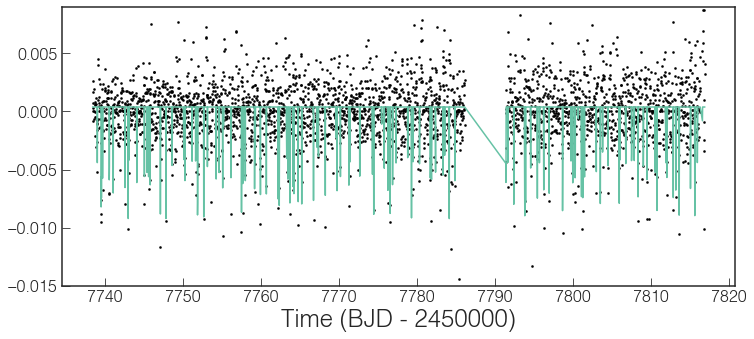

In [12]:
# here are all the transits!!
fig, ax = plt.subplots(1, 1, figsize=[11,5])
ax.scatter(time,flux, color='k',s=4)
ax.plot(time,fitT.transitmodel)
ax.set_ylim(-0.015,0.009)
ax.set_xlabel('Time (BJD - 2450000)')
plt.savefig('images/lc-with-model.png')

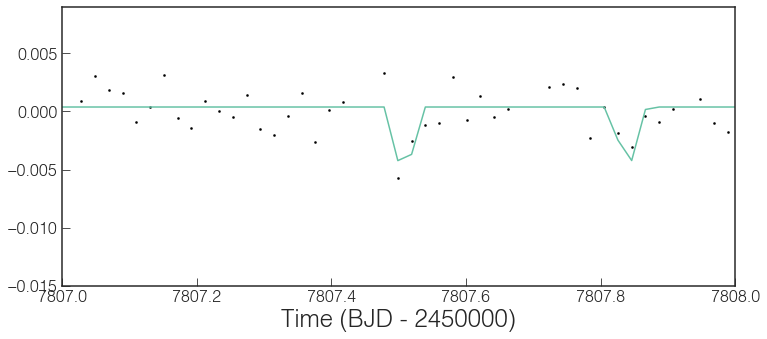

In [18]:
# here are all the transits!!
fig, ax = plt.subplots(1, 1, figsize=[11,5])
ax.scatter(time,flux, color='k',s=4)
ax.plot(time,fitT.transitmodel)
ax.set_ylim(-0.015,0.009)
ax.set_xlim(7807,7808)
ax.set_xlabel('Time (BJD - 2450000)')
# plt.savefig('images/lc-with-model.png')

In [13]:
# some stellar parameters
ld1 = 0.43
ld2 = 0.14
zpt = fitT.fitresultstellar['zpt']
rho = 50.0

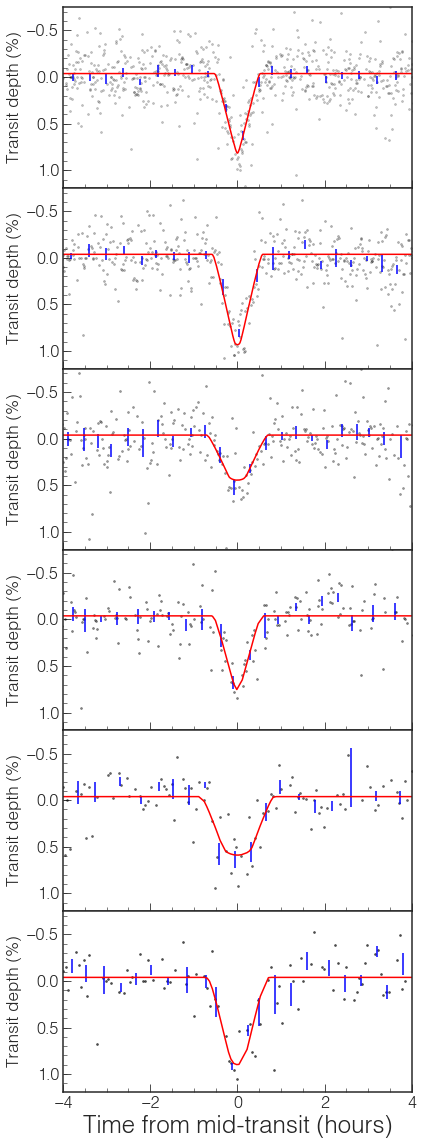

In [14]:
nplanets=6
fig, axes = plt.subplots(nplanets, 1, figsize=[6,16])
for i,p in enumerate(['pnum0','pnum1','pnum2','pnum3','pnum4','pnum5']):
    axes[i] = plot_model(axes[i],time,flux, rho, zpt, ld1, ld2, fitT.fitresultplanets[p])
    axes[i].tick_params(labelbottom=False)
axes[-1].set_xlabel('Time from mid-transit (hours)')
axes[-1].tick_params(labelbottom=True)
fig.subplots_adjust(hspace=0)
plt.tight_layout(h_pad=0)
plt.savefig('images/transitmodel.png')

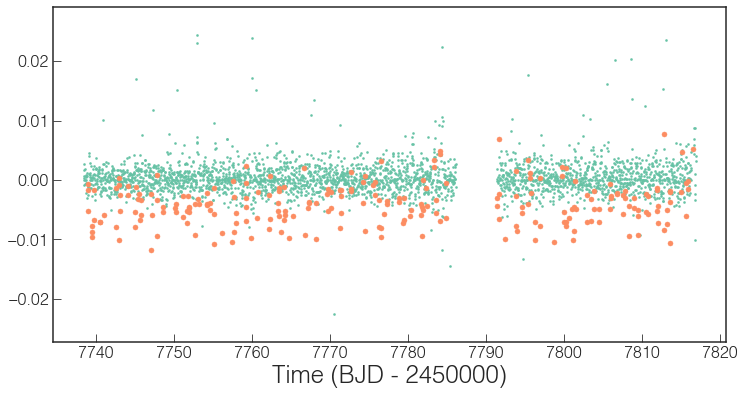

In [15]:
# data in/out of transit
fig, ax = plt.subplots(1, 1, figsize=[11,6])
ax.scatter(time[fitT.transitmodel > 0],flux[fitT.transitmodel > 0], s=4)
ax.scatter(time[fitT.transitmodel <= 0],flux[fitT.transitmodel <= 0], s=25)
ax.set_xlabel('Time (BJD - 2450000)')

### ok let's search for another planets... planet h?

In [19]:
# Main transit search
minPeriod = 15     # Limitations of BLS Fortran code
maxPeriod = 26.#(time[-1] - time[0]) /3.

# outs = doSearch(time,flux - fitT.transitmodel, minPeriod, maxPeriod, )
outs = doSearch(time[fitT.transitmodel > 0],flux[fitT.transitmodel > 0], minPeriod, maxPeriod, )

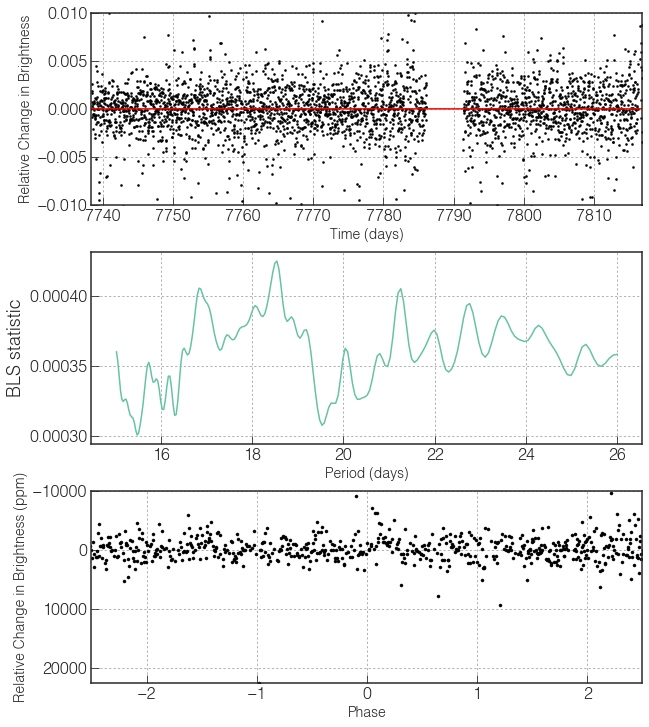

In [20]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=[9,12])
ax1.scatter(time,flux, color='k',s=4)
ax1.plot(time[fitT.transitmodel > 0], outs['transitModel'] , color='r') 
ax1.set_ylim([-0.01,0.01])
ax1.set_xlim(np.min(time), np.max(time))
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('Relative Change in Brightness', fontsize=14)
ax1.grid()
ax2.grid()
ax3.grid()

#ax2.plot(time, flux ) 
ax2.plot(outs['period_guesses'], outs['convolved_bls'])
ax2.set_xlabel('Period (days)', fontsize=14)
ax2.set_ylabel('BLS statistic', fontsize=18)
q,f = get_qf(time[fitT.transitmodel > 0], flux[fitT.transitmodel > 0], outs['epoch'], outs['period'])
ax3.scatter(q,f, s=9, c='k')
ax3.set_ylim([np.max(f),-10000])
#ax3.set_xlim([np.max(q),np.min(q)])
ax3.set_xlim([-2.5,2.5])
ax3.set_xlabel('Phase', fontsize=14)
ax3.set_ylabel('Relative Change in Brightness (ppm)', fontsize=14)


# this isn't very convincing, other poeple are going to do much better :)

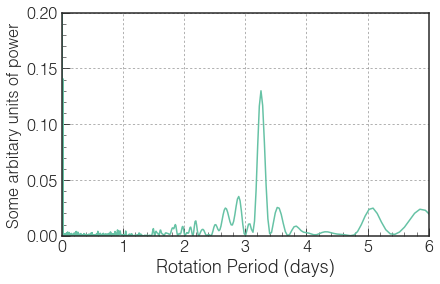

In [55]:
from astropy.stats import LombScargle
cc = corflux - 1.0
frequency, power = LombScargle(t1[np.abs(cc) < 0.015],cc[np.abs(cc) < 0.015]).autopower()
plt.plot(1./frequency, power) 

plt.xlim(0,6)
plt.ylim(0,0.2)
plt.xlabel('Rotation Period (days)', fontsize=18)
plt.ylabel('Some arbitary units of power', fontsize=16)
plt.grid()
plt.minorticks_on()

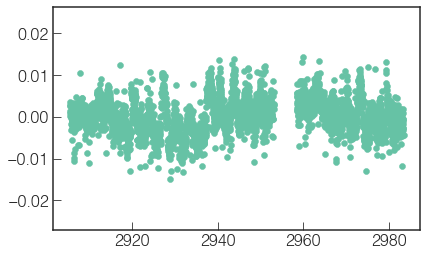

In [40]:
plt.scatter(t1[np.abs(cc) < 0.015],cc[np.abs(cc) < 0.015])